Name:Hadeer Motair

In [49]:
# Import any needed libraries here
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime
from scipy.optimize import minimize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns


Data Preprocessing:
In the below code cell, write your code to load and preprocess the data given to you in the challenge. In the space below this text cell, write any comments you have about your code/reasoning (why you processed the data in a certain way, what you noticed, etc.)

(COMMENTS HERE)

In [ ]:
# Write your preprocessing code in this cell, feel free to add more code cells if needed
def get_risk_free_rate():#FROM GITHUB- used 10 year not 3 month.
    treasury_data = yf.download("^TRX", start="2013-01-01", end=datetime.now().strftime('%Y-%m-%d'))
    latest_annual_rate = treasury_data['Adj Close'].iloc[-1]
    return latest_annual_rate / 100 

data_path = '/Users/amrmotair/Desktop/Q3 - Factor Model/fm_challenge_data.csv'
data = pd.read_csv(data_path)
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data = data.apply(pd.to_numeric, errors='coerce').ffill()


sp500_data = yf.download('^GSPC', start=data.index.min().strftime('%Y-%m-%d'), end=data.index.max().strftime('%Y-%m-%d'))
sp500_monthly = sp500_data['Adj Close'].resample('MS').last().ffill()

# Merge S&P 500 data with data
data = pd.merge(data, sp500_monthly.rename('SP500'), left_index=True, right_index=True, how='left').ffill()


monthly_returns = data.pct_change().ffill().dropna() 


risk_free_rate = get_risk_free_rate()


/Users/amrmotair/trying /.venv/lib/python3.12/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed
/Users/amrmotair/trying /.venv/lib/python3.12/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed


EDA:
In the below code cell, write the code that you used for your EDA. In the space below this text cell, write any comments you have about your code/reasoning (what you checked in your analysis, what you noticed, etc.)

(COMMENTS HERE)

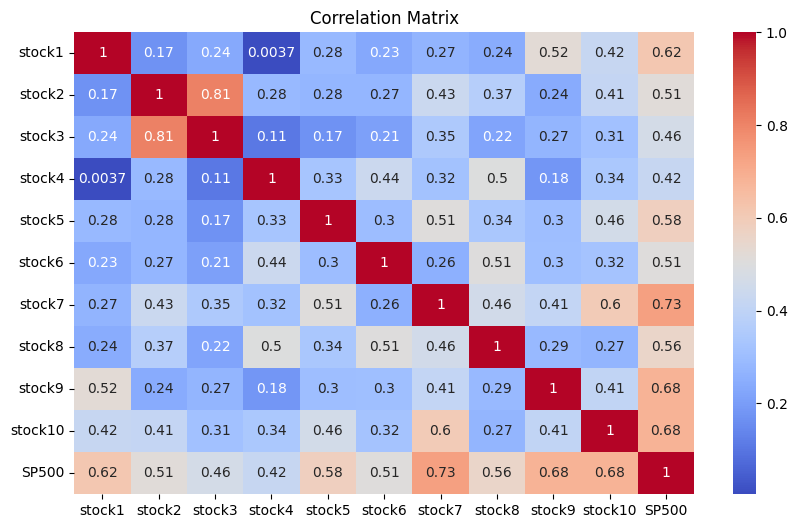

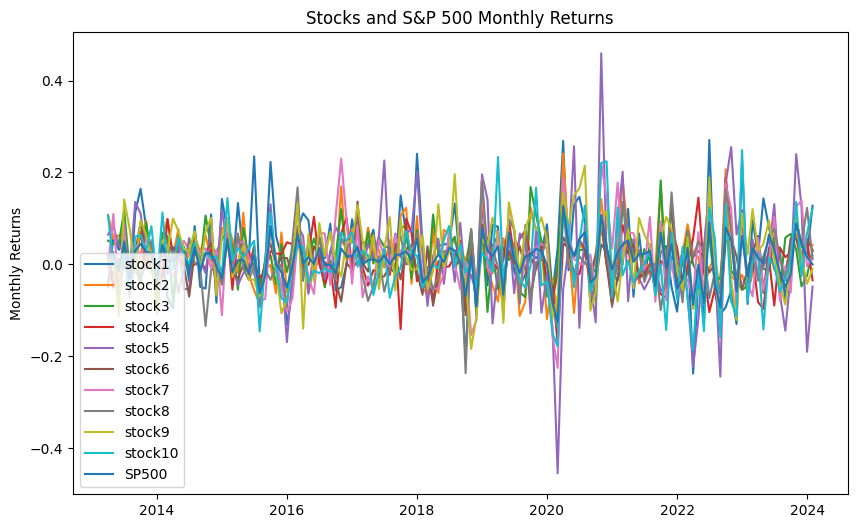

In [51]:
# Write your EDA code in this cell, feel free to add more code cells if needed
### Part 2: Exploratory Data Analysis (EDA)
# Correlation Matrix
plt.figure(figsize=(10, 6))
# Generate and display a heatmap for the correlation matrix of monthly returns.
# 'cmap='coolwarm'' assigns a color map to the correlation values for visual differentiation.
sns.heatmap(monthly_returns.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Stocks and S&P 500 Monthly Returns
plt.figure(figsize=(10, 6))
for stock in monthly_returns.columns:
    plt.plot(monthly_returns.index, monthly_returns[stock], label=stock)
plt.ylabel('Monthly Returns')
plt.title('Stocks and S&P 500 Monthly Returns')
plt.legend()
plt.show()


Model Implementation:
In the below code cell, write your code to implement CAPM and then a model of your choosing to generate the weights for each asset. In the space below this text cell, write any comments you have about your code/reasoning (what model you chose and why, etc.)

(COMMENTS HERE)

In [52]:
# Write your modeling code in this cell, feel free to add more code cells if needed
### Part 3: Model Experimentation (CAPM and Linear Regression as before)
# CAPM Model for Expected Returns
#Capital Asset Pricing Model.ipynb-EXAMPLE MODEL I learned from in github.
market_benchmark = 'SP500'
market_variance = monthly_returns[market_benchmark].var()
betas = {stock: monthly_returns[stock].cov(monthly_returns[market_benchmark]) / market_variance 
         for stock in monthly_returns.columns if stock != market_benchmark}

market_premium = monthly_returns[market_benchmark].mean() * 12 - risk_free_rate
expected_returns_capm = {stock: risk_free_rate + beta * market_premium for stock, beta in betas.items()}



# Portfolio Optimization Function
def optimize_portfolio(returns, risk_free_rate):
    """
    Optimizes portfolio weights to maximize the Sharpe ratio.
    Args:
    returns (pd.DataFrame): DataFrame containing return data for each asset.
    risk_free_rate (float): Risk-free rate, used to calculate Sharpe ratio.
    
    Returns:
        np.array: Array of optimized portfolio weights for maximizing Sharpe ratio."""
    num_assets = len(returns.columns)
    initial_guess = np.ones(num_assets) / num_assets
    bounds = tuple((0, 1) for _ in range(num_assets))#CHAT
    constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}#CHAT

    def neg_sharpe(weights):
        p_returns = np.dot(weights, returns.mean()) * 12  
        p_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 12, weights)))  
        return -(p_returns - risk_free_rate) / p_volatility

    result = minimize(neg_sharpe, initial_guess, method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x


optimized_weights_capm = optimize_portfolio(monthly_returns.drop(columns=[market_benchmark]), risk_free_rate)

# Linear Regression Model for Predicting Future Returns, adjusted to exclude SP500 from predictions
## Train a linear regression model for each stock and predict future returns
# Args: X_train, y_train for fitting; X_test for prediction
# Returns: predicted_returns DataFrame containing predicted future returns for each stock
X = monthly_returns.drop(columns=[market_benchmark]).shift().dropna()
y = monthly_returns.drop(columns=[market_benchmark])[1:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

predicted_returns, actual_returns_test = {}, {}
for stock in y_train.columns:
    model = LinearRegression()
    model.fit(X_train, y_train[stock])
    predicted_returns[stock] = model.predict(X_test)
predicted_returns = pd.DataFrame(predicted_returns, index=X_test.index)

optimized_weights_ml = optimize_portfolio(predicted_returns, risk_free_rate)




Model Backtesting:
In the below code cell, write your code to backtest your model against the benchmark of the S&P 500 and computing your backtesting metrics. In the space below this text cell, write any comments you have about your code/reasoning (what you noticed about the results, etc.)

(COMMENTS HERE)

CAPM Portfolio: Sharpe Ratio = 5.628505392730988 , Volatility = 0.9127093893502627
ML Portfolio: Sharpe Ratio = 5.945576898164114 , Volatility = 0.7259356964346513
Market: Sharpe Ratio = -1.234857020639748 , Volatility = 0.22302581655168338


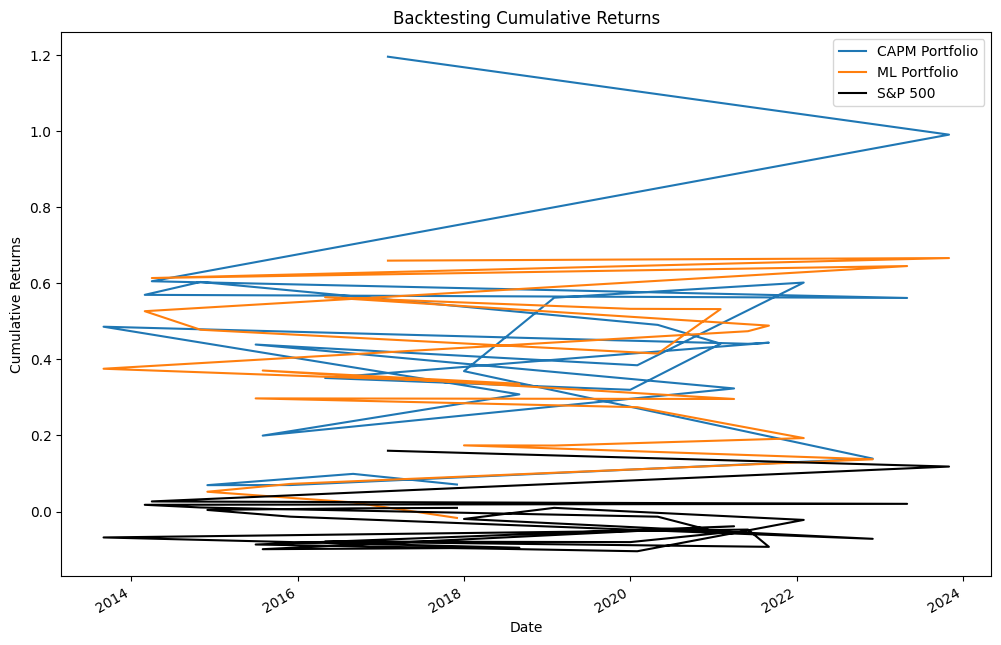

In [53]:


def calculate_performance_metrics(returns):
    """Calculate Sharpe Ratio and Annualized Volatility.FROM GITHUB"""
    sharpe_ratio = returns.mean() / returns.std() * np.sqrt(12)  # Annualized Sharpe Ratio
    annualized_volatility = returns.std() * np.sqrt(12)  # Annualized Volatility
    return sharpe_ratio, annualized_volatility

def backtest(returns, weights):
    """Perform backtesting given returns and portfolio weights."""
    if len(weights) != returns.shape[1]:
        raise ValueError("Weights length does not match number of assets in returns DataFrame")
    portfolio_returns = (returns.dot(weights)).dropna()
    cumulative_returns = (1 + portfolio_returns).cumprod() - 1
    return cumulative_returns


returns_without_benchmark = monthly_returns.drop(columns=[market_benchmark])


cumulative_returns_capm = backtest(returns_without_benchmark.loc[X_test.index], optimized_weights_capm)


cumulative_returns_ml = backtest(predicted_returns, optimized_weights_ml)
cumulative_returns_market = backtest(monthly_returns[[market_benchmark]].loc[X_test.index], [1])

sharpe_ratio_capm, vol_capm = calculate_performance_metrics(cumulative_returns_capm)
sharpe_ratio_ml, vol_ml = calculate_performance_metrics(cumulative_returns_ml)
sharpe_ratio_market, vol_market = calculate_performance_metrics(cumulative_returns_market)

# Display the performance metrics
print("CAPM Portfolio: Sharpe Ratio =", sharpe_ratio_capm, ", Volatility =", vol_capm)
print("ML Portfolio: Sharpe Ratio =", sharpe_ratio_ml, ", Volatility =", vol_ml)
print("Market: Sharpe Ratio =", sharpe_ratio_market, ", Volatility =", vol_market)


plt.figure(figsize=(12, 8))
cumulative_returns_capm.plot(label='CAPM Portfolio')
cumulative_returns_ml.plot(label='ML Portfolio')
cumulative_returns_market.plot(label='S&P 500', color='black')  
plt.legend()
plt.title('Backtesting Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.show()

#Used chat to fix a value error I had where the weights didn't match the data frame.
#This is the part I got from them Let's clean up the code to eliminate redundant or incorrect calls and ensure it runs as intended:
##Remove Redundant Backtesting Calls: The repeated backtesting for the CAPM and ML portfolios right after the initial correct calls should be removed to avoid confusion and errors.
##Correct Use of Adjusted DataFrames: Ensure that you only use the returns_without_benchmark DataFrame for CAPM backtesting and the appropriately prepared predicted_returns DataFrame for ML backtesting. The monthly_returns[['SP500']] is correctly used for the market benchmark comparison.###

References:
In this text cell, please give any references you used (including ChatGPT!), and what you got out of that resource. 